In [ ]:
# train_rcnn.ipynb

In [ ]:
# Imports
import torch
from torch.utils.data import DataLoader
import torchvision
import os
import sys

In [ ]:
# Grab local imports
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(os.path.join(project_root, "src"))

from data.load_data import train_dl, val_dl, unique_imgs
from utils.progress import progress # Couldn't get tqdm to work so just made my own
from models.cnn import CNN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [ ]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# Load pre-trained Faster R-CNN
model = fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Move model to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
# Define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
num_epochs = 2

for epoch in range(num_epochs):
    epoch_loss = 0
    for data in progress(train_dl, total_steps=len(train_dl)):
        #print('.', end='')
        imgs = []
        targets = []
        for d in data:
            imgs.append(d[0].to(device))
            #print('.', end='')
            targ = {}
            targ["boxes"] = d[1]["boxes"].to(device)
            targ["labels"] = d[1]["label"].to(device)
            targets.append(targ)
        
        loss_dict = model(imgs, targets)
        loss = sum(v for v in loss_dict.values())
        epoch_loss += loss.cpu().detach().numpy()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Save trained model
torch.save(model.state_dict(), "faster_rcnn_trained.pth")


In [29]:
import torch
import numpy as np
from sklearn.metrics import mean_squared_error
import pandas as pd

bbox_df = pd.read_csv('../data/bbox_train.csv')

def validate(model, dataloader, bbox_df, unique_imgs, threshold=0.5, max_batches=100):
    model.eval()
    device = next(model.parameters()).device

    count_diffs = []
    all_rmse = []
    correct_count = 0
    total_samples = 0

    with torch.no_grad():
        for i, batch in enumerate(progress(dataloader, total_steps=max_batches+1 if max_batches < len(dataloader) else len(dataloader))):
            if i >= max_batches:
                break

            for img_tensor, target in batch:
                img_tensor = img_tensor.to(device)
                img_index = target["img_index"].item()
                image_name = unique_imgs[img_index]

                # Predict
                pred = model([img_tensor])[0]
                pred_boxes = pred["boxes"][pred["scores"] > threshold].cpu().numpy()

                # Ground truth boxes
                gt_boxes = bbox_df[bbox_df["Name"] == image_name][["xmin", "ymin", "xmax", "ymax"]].values

                # Count accuracy
                pred_count = len(pred_boxes)
                true_count = len(gt_boxes)
                count_diffs.append(abs(pred_count - true_count))

                if pred_count == true_count:
                    correct_count += 1
                total_samples += 1

                # RMSE for center points, only if counts match
                if pred_count == true_count and pred_count > 0:
                    gt_centers = np.array([((x1 + x2) / 2, (y1 + y2) / 2) for x1, y1, x2, y2 in gt_boxes])
                    pred_centers = np.array([((x1 + x2) / 2, (y1 + y2) / 2) for x1, y1, x2, y2 in pred_boxes])

                    mse = mean_squared_error(gt_centers, pred_centers)
                    rmse = np.sqrt(mse)
                    all_rmse.append(rmse)

    avg_count_diff = np.mean(count_diffs)
    avg_rmse = np.mean(all_rmse) if all_rmse else float('nan')
    accuracy = (correct_count / total_samples) * 100 if total_samples > 0 else 0

    print(f"\n📊 Validation Results:")
    print(f"- Accuracy (exact count match): {accuracy:.2f}%")
    print(f"- Avg Count Difference: {avg_count_diff:.2f}")
    print(f"- RMSE (when counts match): {avg_rmse:.2f}")

    return avg_count_diff, avg_rmse, accuracy


validate(model, val_dl, bbox_df, unique_imgs, max_batches=30_000)

Progress: 100.00% completed | ETA: 00m 00s

📊 Validation Results:
- Accuracy (exact count match): 75.42%
- Avg Count Difference: 0.39
- RMSE (when counts match): 81.45


(np.float64(0.3898042256251211),
 np.float64(81.45320233123812),
 75.4215933320411)

c:\Users\agill\OneDrive\Documents\GitHub\CSC4260-Project\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


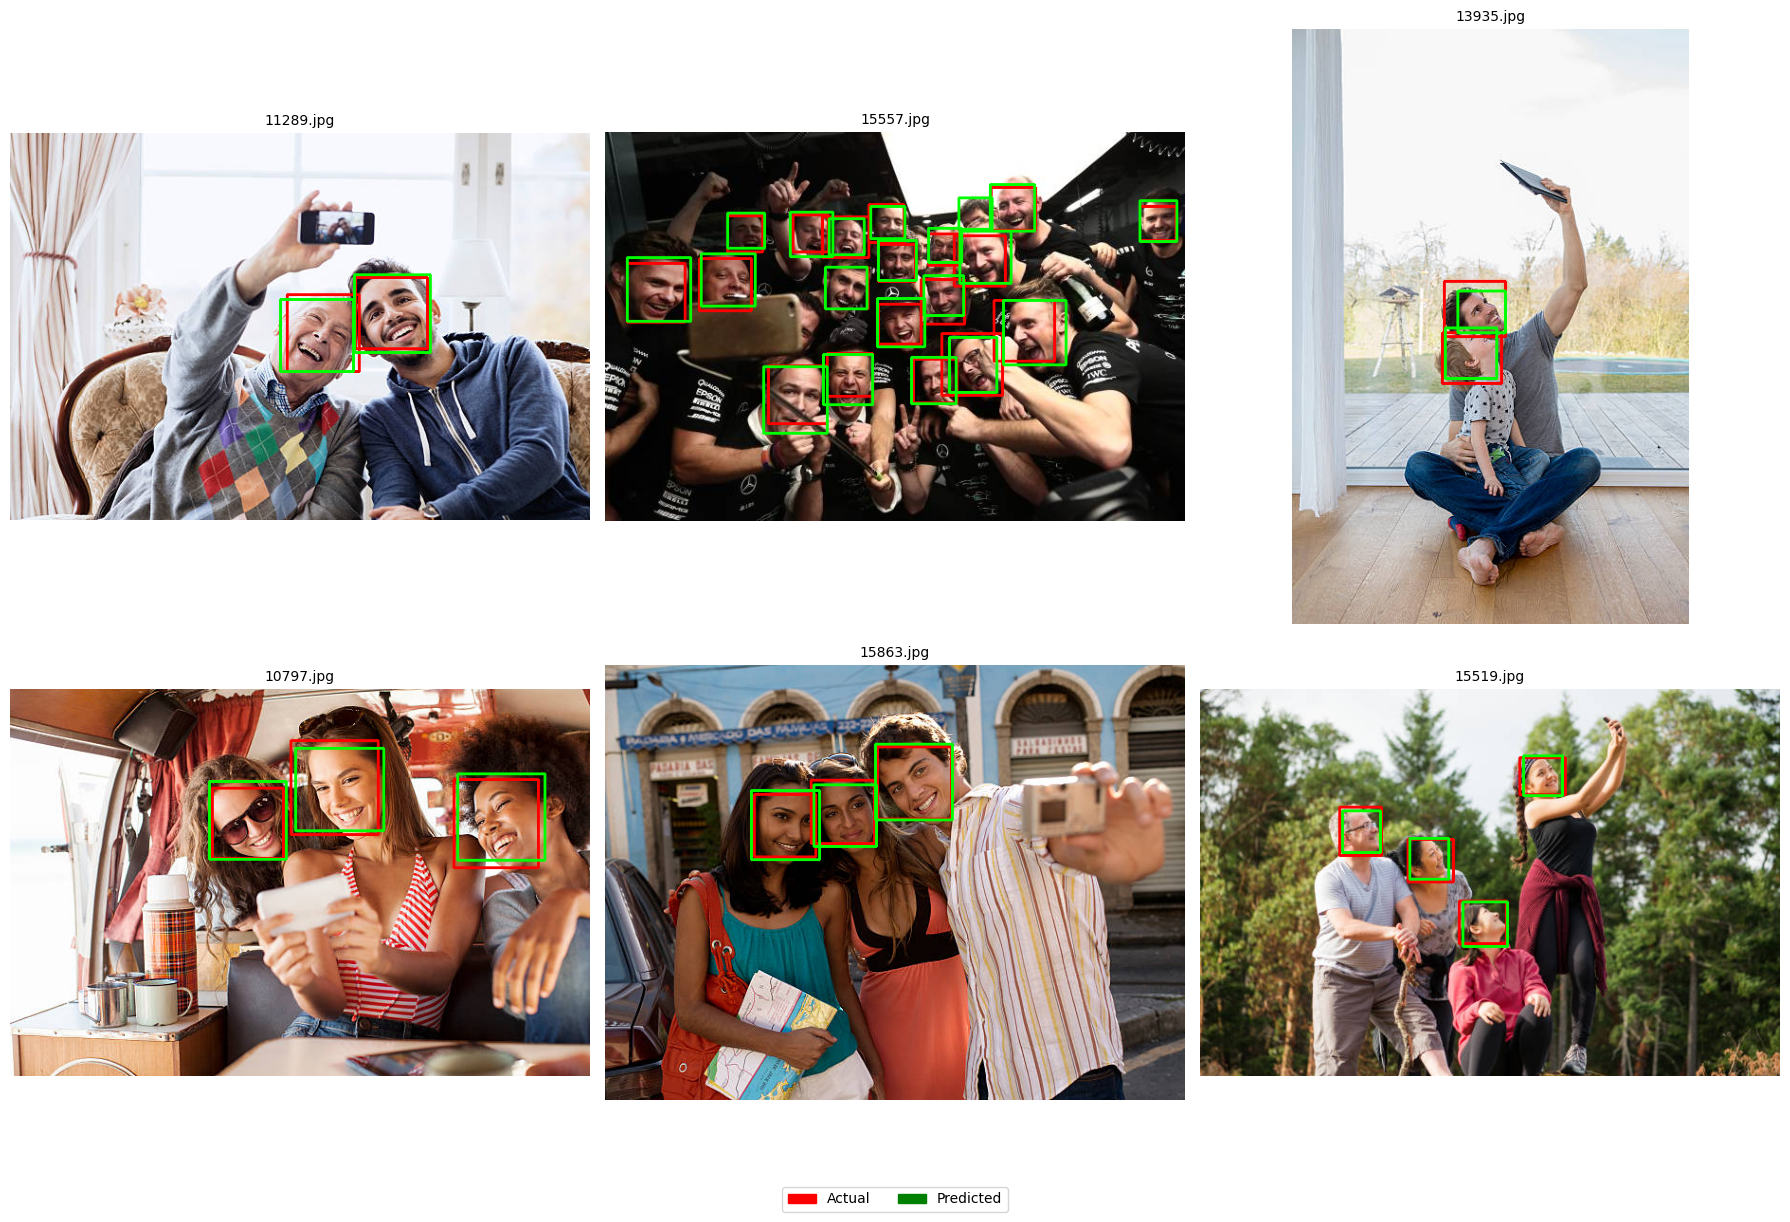

In [34]:
import matplotlib.patches as mpatches
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import torchvision.transforms as T
import random

# Define model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=False)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, 2)

# Load weights
model.load_state_dict(torch.load("faster_rcnn_trained.pth", map_location="cpu"))

# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Paths
IMAGE_DATA_PATH = "../data/image_data/"
BBOX_PATH = "../data/bbox_train.csv"

# Load ground truth boxes once
bbox_df = pd.read_csv(BBOX_PATH)

# Simple ToTensor transform
to_tensor = T.ToTensor()

def get_random_img_from_val_dl():
    batch = next(iter(val_dl))
    img_tensor, target = random.choice(batch)
    img_index = target["img_index"].item()
    image_name = unique_imgs[img_index]
    return img_tensor, image_name

def visualize_batch_predictions_from_val_dl(num_images=6):
    cols = 3
    rows = (num_images + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 6))
    axes = axes.flatten()

    for i in range(num_images):
        # Get random image from val_dl
        img_tensor, img_name = get_random_img_from_val_dl()

        # Get original size
        image_path = os.path.join(IMAGE_DATA_PATH, img_name)
        with Image.open(image_path) as orig_img:
            orig_w, orig_h = orig_img.size

        # Prepare image
        image_np = (img_tensor.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8).copy()

        # Run model
        model.eval()
        with torch.no_grad():
            prediction = model(img_tensor.unsqueeze(0).to(device))

        # Scale factors
        new_h, new_w = img_tensor.shape[1:]
        x_scale = new_w / orig_w
        y_scale = new_h / orig_h

        # Ground truth boxes (red)
        gt_boxes = bbox_df[bbox_df["Name"] == img_name][["xmin", "ymin", "xmax", "ymax"]].values
        for xmin, ymin, xmax, ymax in gt_boxes:
            xmin = int(xmin * x_scale)
            xmax = int(xmax * x_scale)
            ymin = int(ymin * y_scale)
            ymax = int(ymax * y_scale)
            cv2.rectangle(image_np, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)

        # Predicted boxes (green)
        for box, score in zip(prediction[0]["boxes"], prediction[0]["scores"]):
            if score > 0.5:
                x1, y1, x2, y2 = map(int, box.tolist())
                cv2.rectangle(image_np, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Plot in grid
        axes[i].imshow(image_np)
        axes[i].set_title(f"{img_name}", fontsize=10)
        axes[i].axis("off")

    # Remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Add legend (outside grid)
    red_patch = mpatches.Patch(color='red', label='Actual')
    green_patch = mpatches.Patch(color='green', label='Predicted')
    fig.legend(handles=[red_patch, green_patch], loc='lower center', bbox_to_anchor=(0.5, -0.02), ncol=2)

    plt.tight_layout()
    plt.show()


visualize_batch_predictions_from_val_dl()
